# Facial Expression Recognition

In [26]:
import pandas as pd
import random
import warnings
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.express as px
from tensorflow.keras import regularizers


# Use the magic command to enable plotting in Colab
%matplotlib inline

# Disable warnings
warnings.simplefilter("ignore")

# Check if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")



GPU is available


In [3]:
#load dataset
data = pd.read_csv("fer2013.csv")
data.shape

(35887, 3)

In [4]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [5]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Data Pre-Processing

In [9]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] ,
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

#Shuffling Data

In [10]:
data = data.sample(frac=1)

#One Hot Encoding

In [11]:
labels = to_categorical(data[['emotion']], num_classes=7)

In [12]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

#Standardization


In [13]:
pixels = train_pixels.reshape((35887*2304,1))

In [14]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

#Reshaping the data (48,48)

In [15]:
pixels = train_pixels.reshape((35887, 48, 48,1))

#Train test validation split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


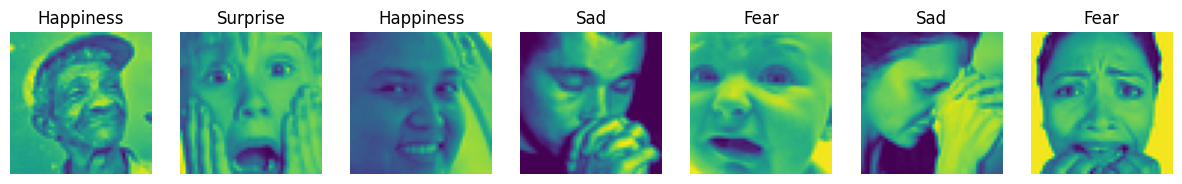

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

#Data augmentation using ImageDataGenerator

In [21]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [22]:
datagen.fit(X_train)
valgen.fit(X_val)

In [23]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

# Training models

In [24]:
def cnn_model():
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(48, 48, 1)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))

    model.compile(
        optimizer=Adam(lr=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


#Adam

In [27]:
model = cnn_model()

In [29]:
 model.compile(
        optimizer=Adam(lr=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
 )

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [31]:
#early stopping
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=5),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode="max")
]

In [32]:
history=model.fit(train_generator,epochs=60,batch_size=64,verbose=1,callbacks=[checkpointer],validation_data=val_generator)

Epoch 1/60
454/455 [============================>.] - ETA: 0s - loss: 6.7675 - accuracy: 0.2090
Epoch 1: val_accuracy improved from -inf to 0.23653, saving model to best_model.h5
455/455 [==============================] - 42s 54ms/step - loss: 6.7579 - accuracy: 0.2093 - val_loss: 2.5267 - val_accuracy: 0.2365
Epoch 2/60
454/455 [============================>.] - ETA: 0s - loss: 2.4507 - accuracy: 0.2696
Epoch 2: val_accuracy improved from 0.23653 to 0.30681, saving model to best_model.h5
455/455 [==============================] - 23s 50ms/step - loss: 2.4507 - accuracy: 0.2697 - val_loss: 2.4088 - val_accuracy: 0.3068
Epoch 3/60
455/455 [==============================] - ETA: 0s - loss: 2.5313 - accuracy: 0.3549
Epoch 3: val_accuracy improved from 0.30681 to 0.31084, saving model to best_model.h5
455/455 [==============================] - 25s 54ms/step - loss: 2.5313 - accuracy: 0.3549 - val_loss: 2.7222 - val_accuracy: 0.3108
Epoch 4/60
455/455 [==============================] - ETA:

Exception ignored in: <function _xla_gc_callback at 0x7cf02da0eef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


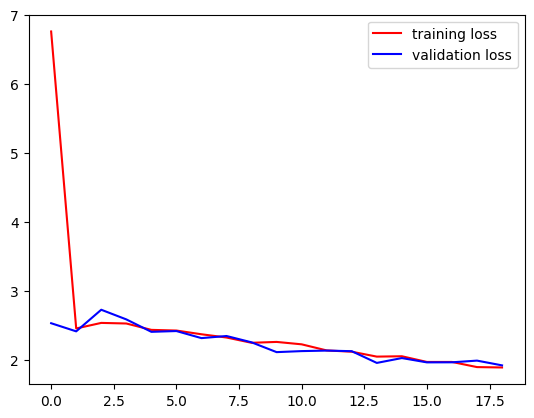

In [33]:
plt.plot(history.history['loss'],'r',label="training loss")
plt.plot(history.history["val_loss"],'b',label='validation loss')
plt.legend()

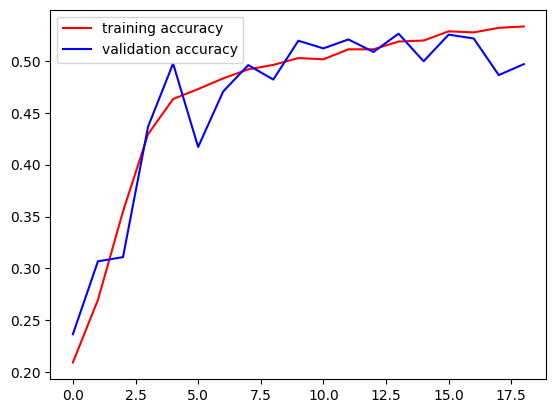

In [34]:
plt.plot(history.history['accuracy'],'r',label="training accuracy")
plt.plot(history.history["val_accuracy"],'b',label='validation accuracy')
plt.legend()

In [35]:
loss=model.evaluate(X_test,y_test)
print('test acc '+str(loss[1]))

113/113 [==============================] - 2s 10ms/step - loss: 1.9388 - accuracy: 0.5258
test acc 0.5257731676101685


In [36]:
preds=model.predict(X_test)
y_pred=np.argmax(preds,axis=1)

113/113 [==============================] - 1s 6ms/step


1/1 [==============================] - 0s 17ms/step


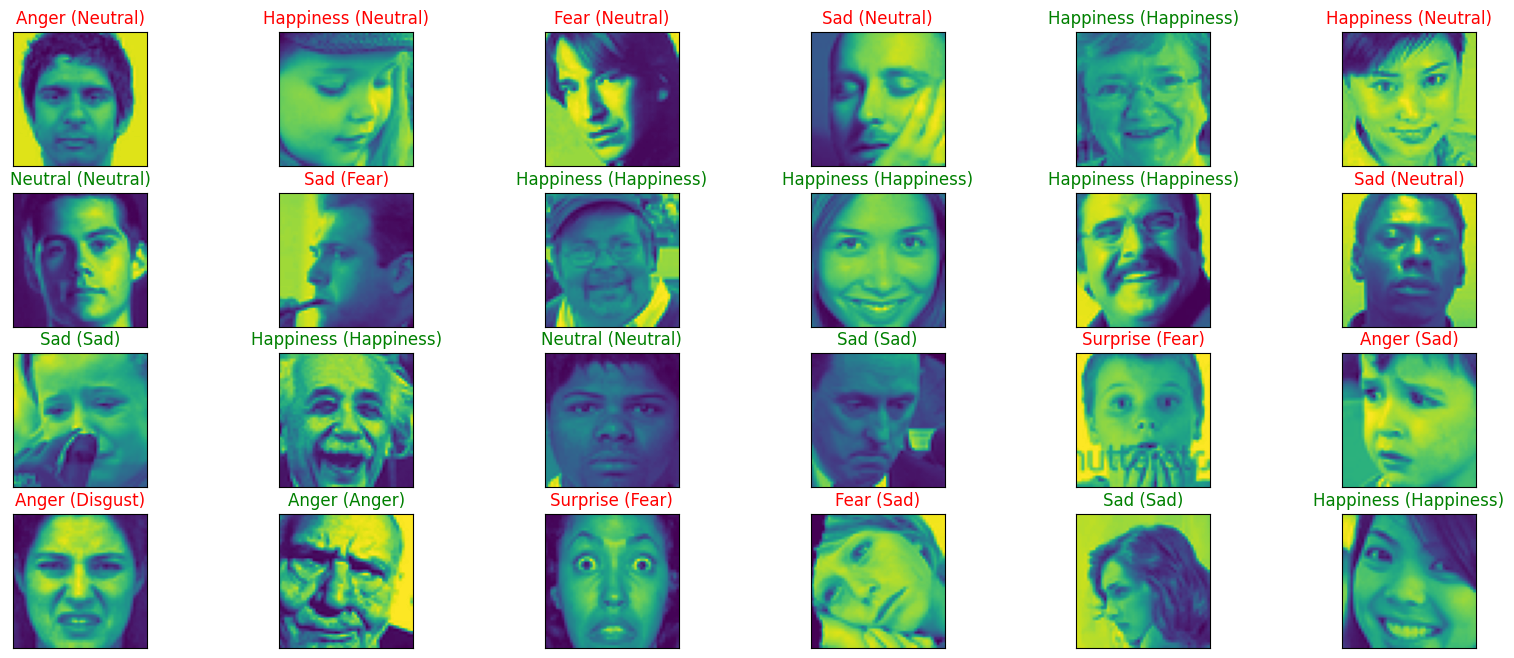

In [37]:
label_dict = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

figure = plt.figure(figsize=(20, 8))  # Fixed the typo in figsize

for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))  # Removed the extra square bracket in np.squeeze(X_test[index])]
    true_index = label_dict[np.argmax(y_test, axis=1)[index]]
    predict_index = label_dict[np.argmax(model.predict(np.expand_dims(X_test[index], axis=0)), axis=1)[0]]  # Added prediction logic
    ax.set_title("{} ({})".format(predict_index, true_index), color='green' if predict_index == true_index else 'red')

plt.show()  # Added plt.show() to display the figure


113/113 [==============================] - 1s 12ms/step


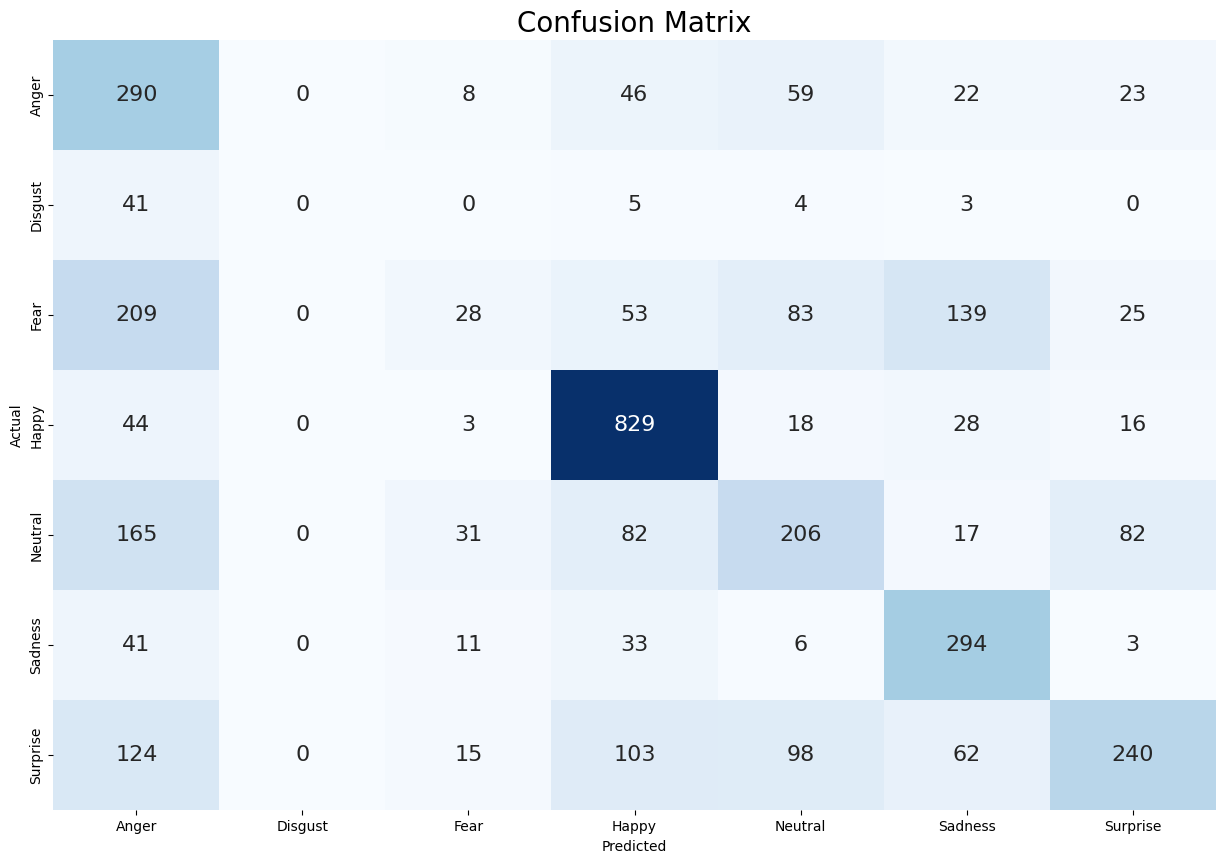

In [39]:
import seaborn as sns
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Assuming model.predict returns probabilities
y_pred_probs = model.predict(X_test)

# Use argmax along axis=1 to get the predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap='Blues', annot=True, annot_kws={'size': 16}, fmt='g')
plt.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.317     0.647     0.426       448
           1      0.000     0.000     0.000        53
           2      0.292     0.052     0.088       537
           3      0.720     0.884     0.794       938
           4      0.435     0.353     0.390       583
           5      0.520     0.758     0.617       388
           6      0.617     0.374     0.466       642

    accuracy                          0.526      3589
   macro avg      0.414     0.438     0.397      3589
weighted avg      0.509     0.526     0.487      3589



# SGD

In [41]:
#fine tuning
model=cnn_model()

In [42]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
#early stopping
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=5),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode="max")
]


In [44]:
history=model.fit(train_generator,epochs=60,batch_size=64,verbose=1,callbacks=[checkpointer],validation_data=val_generator)

Epoch 1/60
455/455 [==============================] - ETA: 0s - loss: 14.8029 - accuracy: 0.1619
Epoch 1: val_accuracy improved from -inf to 0.20960, saving model to best_model.h5
455/455 [==============================] - 30s 59ms/step - loss: 14.8029 - accuracy: 0.1619 - val_loss: 14.0819 - val_accuracy: 0.2096
Epoch 2/60
455/455 [==============================] - ETA: 0s - loss: 14.3887 - accuracy: 0.1771
Epoch 2: val_accuracy did not improve from 0.20960
455/455 [==============================] - 24s 52ms/step - loss: 14.3887 - accuracy: 0.1771 - val_loss: 13.8253 - val_accuracy: 0.2040
Epoch 3/60
455/455 [==============================] - ETA: 0s - loss: 14.0513 - accuracy: 0.1889
Epoch 3: val_accuracy improved from 0.20960 to 0.23839, saving model to best_model.h5
455/455 [==============================] - 23s 50ms/step - loss: 14.0513 - accuracy: 0.1889 - val_loss: 13.5758 - val_accuracy: 0.2384
Epoch 4/60
454/455 [============================>.] - ETA: 0s - loss: 13.7475 - accu

In [45]:
loss=model.evaluate(X_test,y_test)
print('test accuracy'+str(loss[1]))

113/113 [==============================] - 1s 8ms/step - loss: 10.9560 - accuracy: 0.2976
test accuracy0.2975759208202362


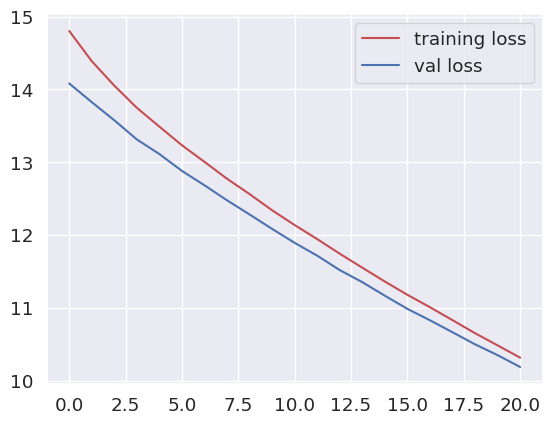

In [46]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],'b',label='val loss')
plt.legend()

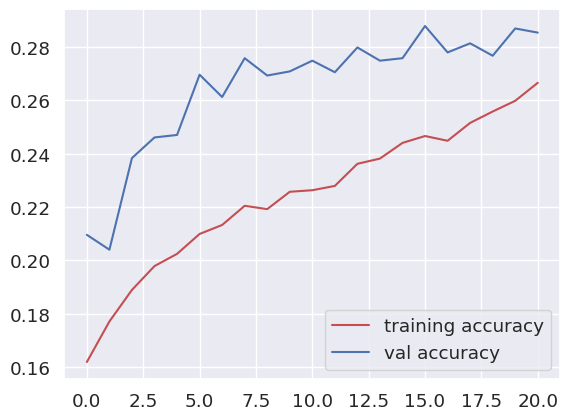

In [47]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],'b',label='val accuracy')
plt.legend()

In [48]:
loss=model.evaluate(X_test,y_test)
print('test acc '+str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 10.9560 - accuracy: 0.2976
test acc 0.2975759208202362


#RMS prop

In [50]:
model = cnn_model()

# Train the model with RMSprop optimizer
model.compile(
    optimizer=RMSprop(lr=0.0001),  # Adjust the learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
#early stopping
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=5),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode="max")
]


In [52]:
history=model.fit(train_generator,epochs=60,batch_size=64,verbose=1,callbacks=[checkpointer],validation_data=val_generator)

Epoch 1/60
454/455 [============================>.] - ETA: 0s - loss: 4.8294 - accuracy: 0.1994
Epoch 1: val_accuracy improved from -inf to 0.21053, saving model to best_model.h5
455/455 [==============================] - 29s 56ms/step - loss: 4.8240 - accuracy: 0.1995 - val_loss: 2.5896 - val_accuracy: 0.2105
Epoch 2/60
454/455 [============================>.] - ETA: 0s - loss: 2.3087 - accuracy: 0.2292
Epoch 2: val_accuracy improved from 0.21053 to 0.26594, saving model to best_model.h5
455/455 [==============================] - 24s 52ms/step - loss: 2.3086 - accuracy: 0.2293 - val_loss: 2.2224 - val_accuracy: 0.2659
Epoch 3/60
455/455 [==============================] - ETA: 0s - loss: 2.1226 - accuracy: 0.2442
Epoch 3: val_accuracy did not improve from 0.26594
455/455 [==============================] - 23s 50ms/step - loss: 2.1226 - accuracy: 0.2442 - val_loss: 2.0866 - val_accuracy: 0.2656
Epoch 4/60
455/455 [==============================] - ETA: 0s - loss: 2.0397 - accuracy: 0.24

In [53]:
loss=model.evaluate(X_test,y_test)
print('test accuracy'+str(loss[1]))

113/113 [==============================] - 1s 8ms/step - loss: 1.3724 - accuracy: 0.5874
test accuracy0.5873502492904663


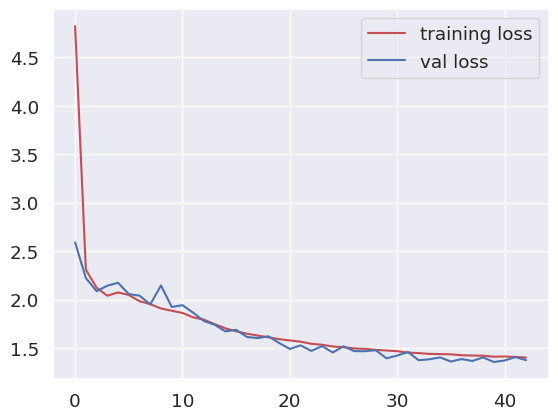

In [54]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],'b',label='val loss')
plt.legend()

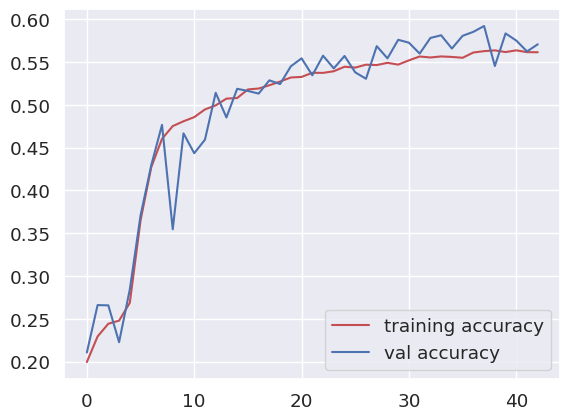

In [55]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],'b',label='val accuracy')
plt.legend()

In [56]:
loss=model.evaluate(X_test,y_test)
print('test acc '+str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 1.3724 - accuracy: 0.5874
test acc 0.5873502492904663


In [61]:
preds=model.predict(X_test)
y_pred=np.argmax(preds,axis=1)

113/113 [==============================] - 2s 13ms/step


1/1 [==============================] - 0s 34ms/step


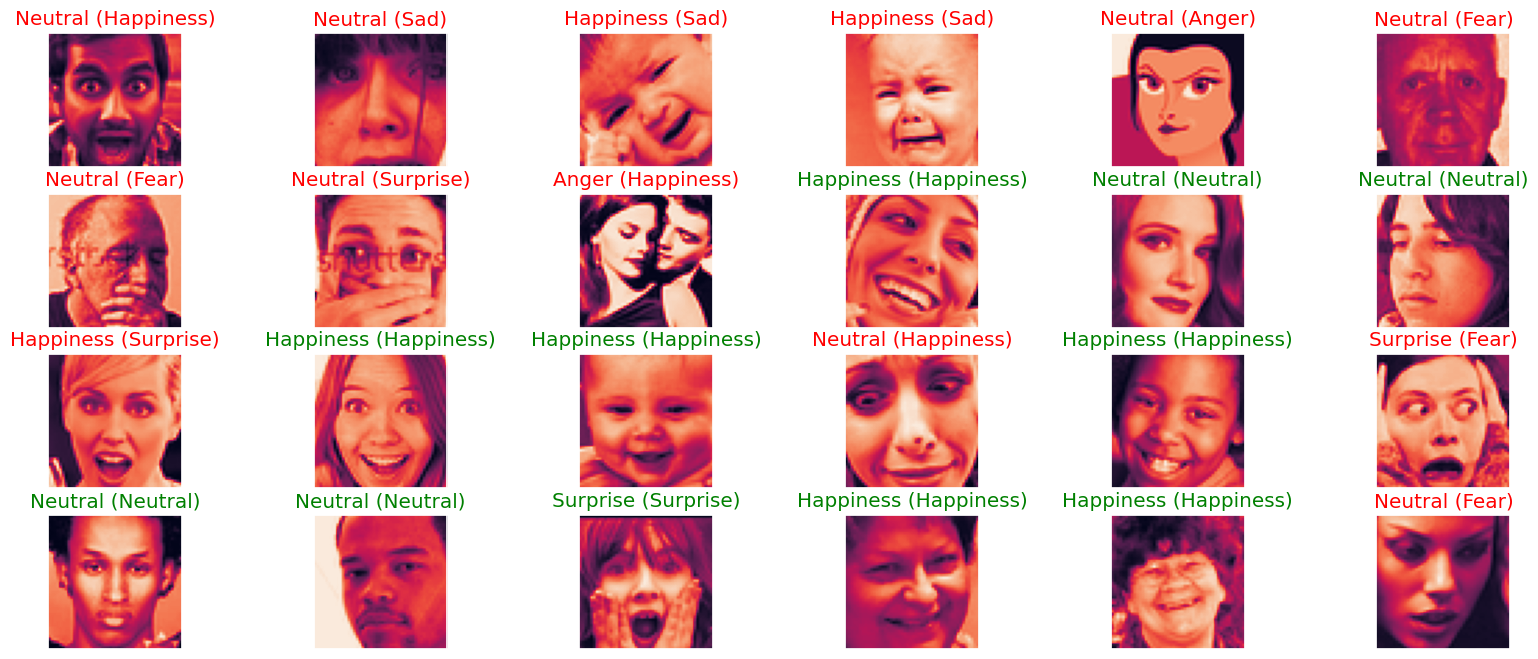

In [62]:
label_dict = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

figure = plt.figure(figsize=(20, 8))  # Fixed the typo in figsize

for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))  # Removed the extra square bracket in np.squeeze(X_test[index])]
    true_index = label_dict[np.argmax(y_test, axis=1)[index]]
    predict_index = label_dict[np.argmax(model.predict(np.expand_dims(X_test[index], axis=0)), axis=1)[0]]  # Added prediction logic
    ax.set_title("{} ({})".format(predict_index, true_index), color='green' if predict_index == true_index else 'red')

plt.show()  # Added plt.show() to display the figure


113/113 [==============================] - 1s 9ms/step


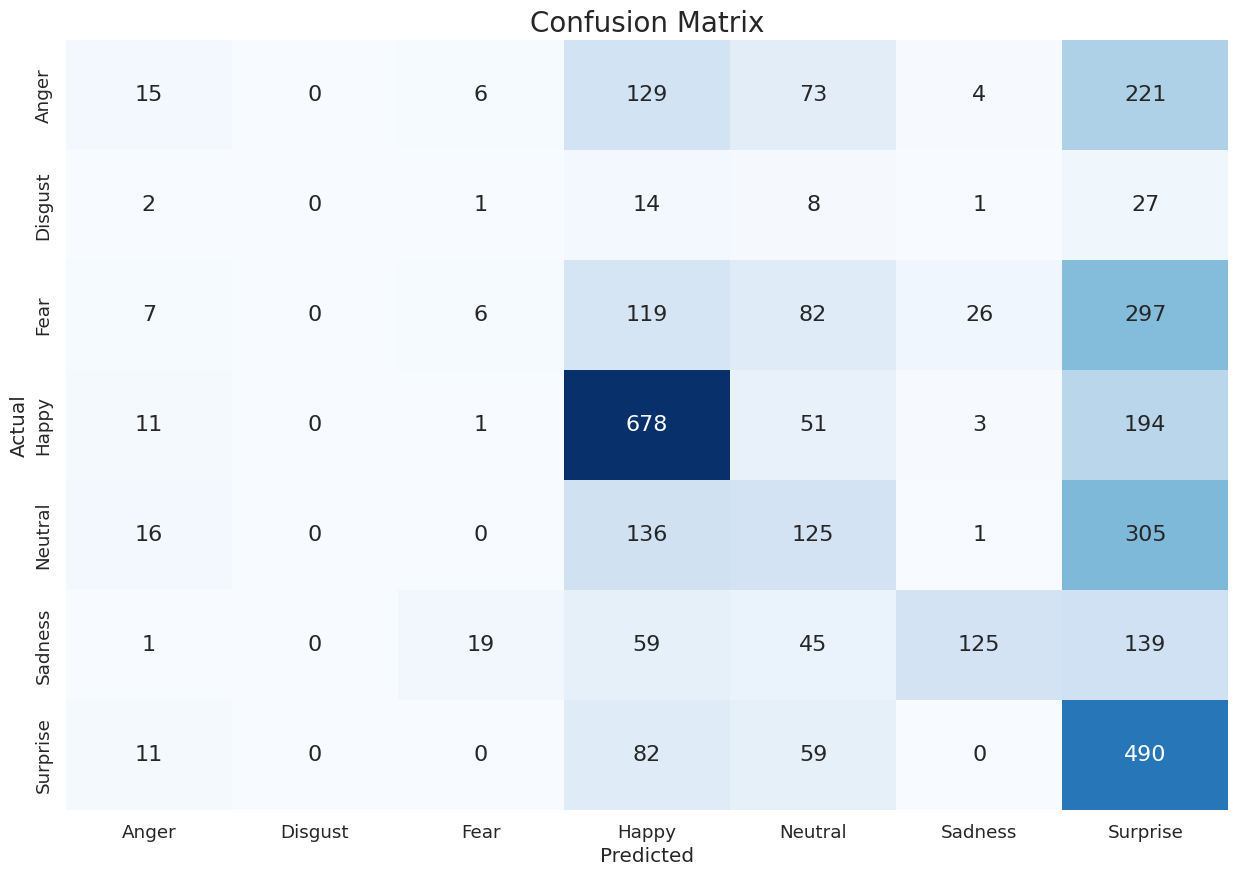

In [63]:
import seaborn as sns
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Assuming model.predict returns probabilities
y_pred_probs = model.predict(X_test)

# Use argmax along axis=1 to get the predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap='Blues', annot=True, annot_kws={'size': 16}, fmt='g')
plt.show()

In [64]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.238     0.033     0.059       448
           1      0.000     0.000     0.000        53
           2      0.182     0.011     0.021       537
           3      0.557     0.723     0.629       938
           4      0.282     0.214     0.244       583
           5      0.781     0.322     0.456       388
           6      0.293     0.763     0.423       642

    accuracy                          0.401      3589
   macro avg      0.333     0.295     0.262      3589
weighted avg      0.385     0.401     0.340      3589



# Adamax

In [65]:
model = cnn_model()

# Train the model with Adamax optimizer
model.compile(
    optimizer=Adamax(lr=0.0001),  # Adjust the learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [66]:
#early stopping
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=5),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode="max")
]

In [67]:
history=model.fit(train_generator,epochs=60,batch_size=64,verbose=1,callbacks=[checkpointer],validation_data=val_generator)

Epoch 1/60
455/455 [==============================] - ETA: 0s - loss: 11.6827 - accuracy: 0.2052
Epoch 1: val_accuracy improved from -inf to 0.26594, saving model to best_model.h5
455/455 [==============================] - 30s 51ms/step - loss: 11.6827 - accuracy: 0.2052 - val_loss: 8.3618 - val_accuracy: 0.2659
Epoch 2/60
454/455 [============================>.] - ETA: 0s - loss: 6.4011 - accuracy: 0.2333
Epoch 2: val_accuracy improved from 0.26594 to 0.27740, saving model to best_model.h5
455/455 [==============================] - 24s 52ms/step - loss: 6.3975 - accuracy: 0.2331 - val_loss: 4.6188 - val_accuracy: 0.2774
Epoch 3/60
454/455 [============================>.] - ETA: 0s - loss: 3.7700 - accuracy: 0.2660
Epoch 3: val_accuracy improved from 0.27740 to 0.30898, saving model to best_model.h5
455/455 [==============================] - 24s 53ms/step - loss: 3.7684 - accuracy: 0.2661 - val_loss: 3.0845 - val_accuracy: 0.3090
Epoch 4/60
454/455 [============================>.] - ET

In [68]:
loss=model.evaluate(X_test,y_test)
print('test accuracy'+str(loss[1]))

113/113 [==============================] - 1s 8ms/step - loss: 1.5187 - accuracy: 0.6110
test accuracy0.6110337376594543


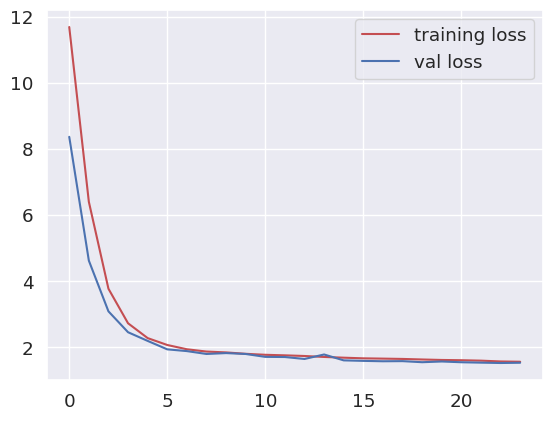

In [69]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],'b',label='val loss')
plt.legend()

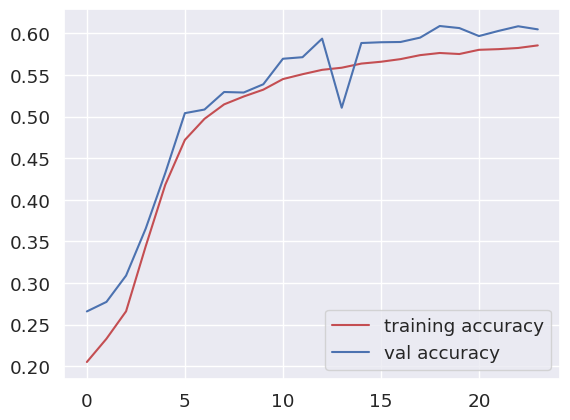

In [70]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],'b',label='val accuracy')
plt.legend()

In [71]:
loss=model.evaluate(X_test,y_test)
print('test acc '+str(loss[1]))

113/113 [==============================] - 1s 8ms/step - loss: 1.5187 - accuracy: 0.6110
test acc 0.6110337376594543


1/1 [==============================] - 0s 19ms/step


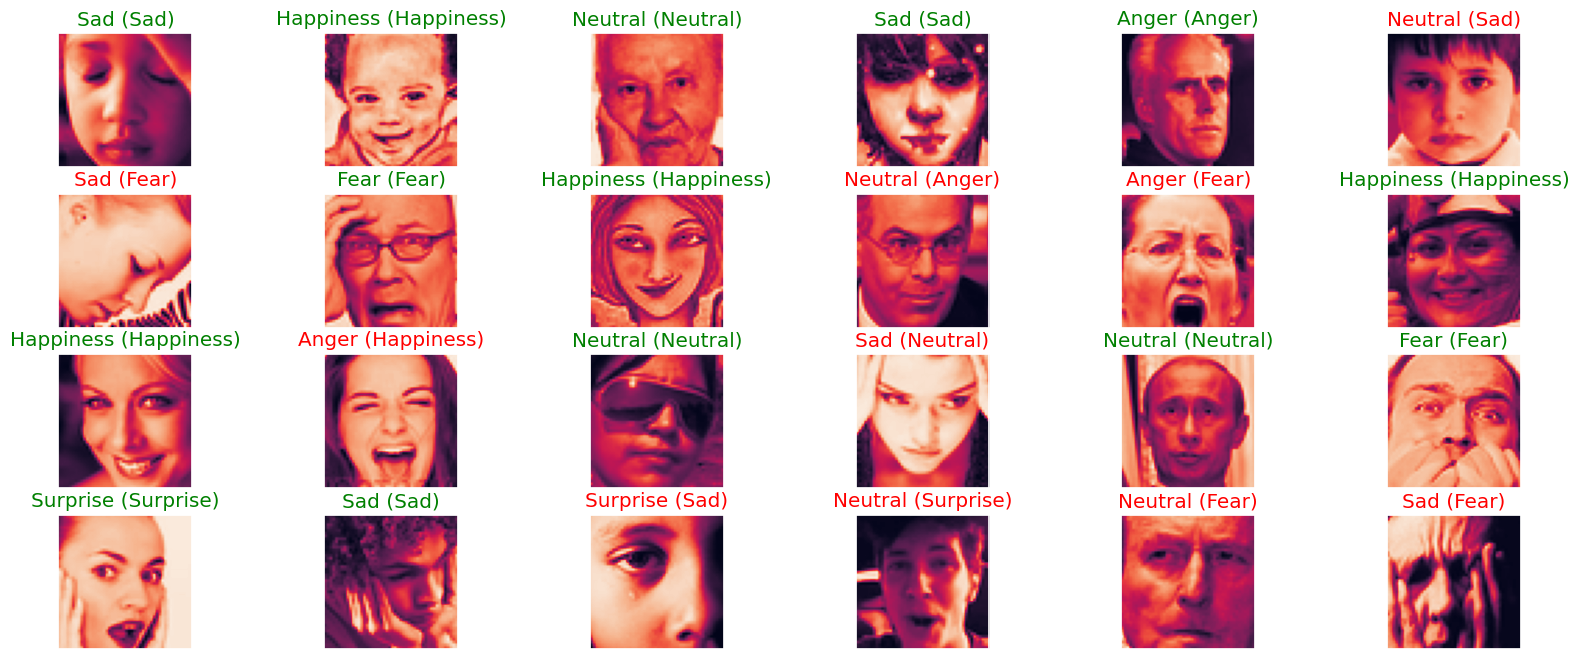

In [72]:
label_dict = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

figure = plt.figure(figsize=(20, 8))  # Fixed the typo in figsize

for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))  # Removed the extra square bracket in np.squeeze(X_test[index])]
    true_index = label_dict[np.argmax(y_test, axis=1)[index]]
    predict_index = label_dict[np.argmax(model.predict(np.expand_dims(X_test[index], axis=0)), axis=1)[0]]  # Added prediction logic
    ax.set_title("{} ({})".format(predict_index, true_index), color='green' if predict_index == true_index else 'red')

plt.show()  # Added plt.show() to display the figure

113/113 [==============================] - 1s 6ms/step


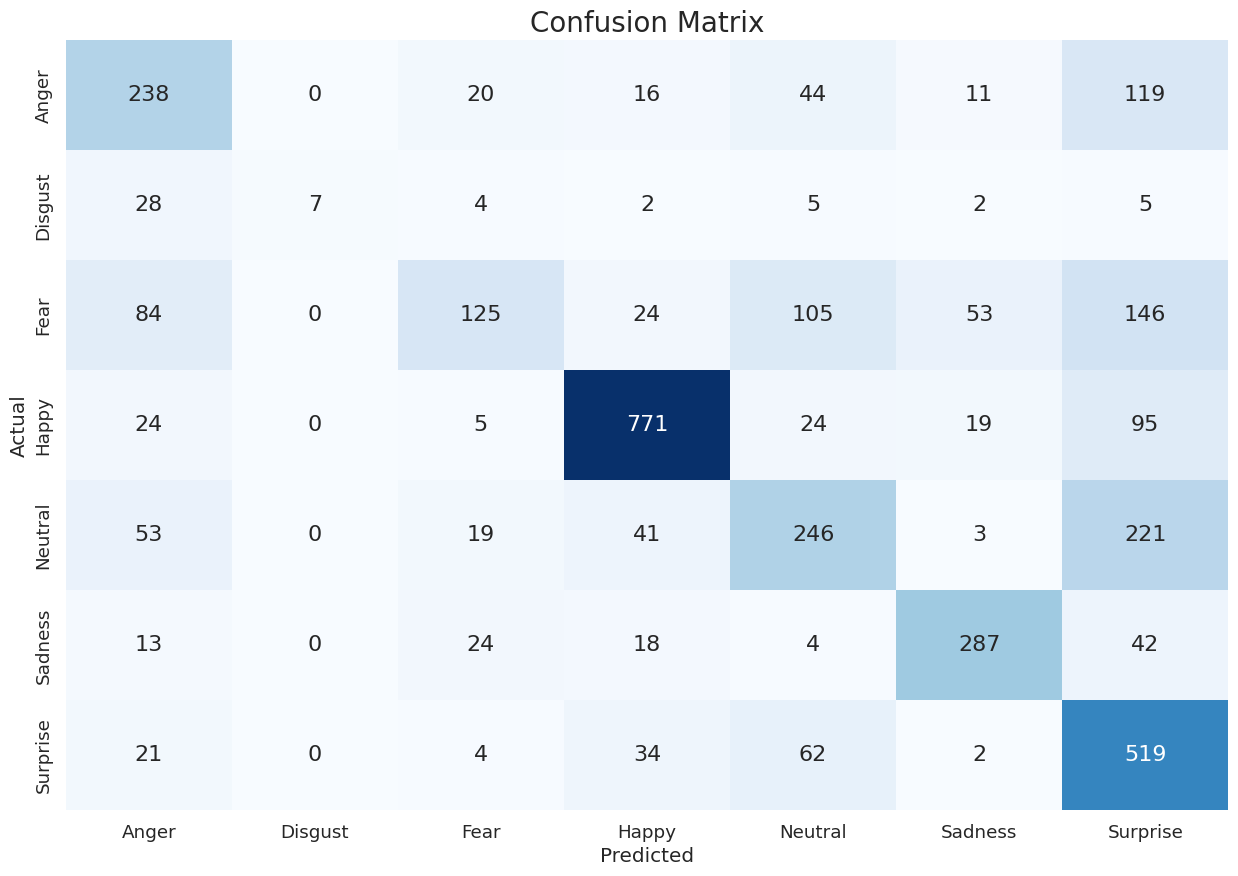

In [73]:
import seaborn as sns
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Assuming model.predict returns probabilities
y_pred_probs = model.predict(X_test)

# Use argmax along axis=1 to get the predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap='Blues', annot=True, annot_kws={'size': 16}, fmt='g')
plt.show()

In [74]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.516     0.531     0.524       448
           1      1.000     0.132     0.233        53
           2      0.622     0.233     0.339       537
           3      0.851     0.822     0.836       938
           4      0.502     0.422     0.459       583
           5      0.761     0.740     0.750       388
           6      0.452     0.808     0.580       642

    accuracy                          0.611      3589
   macro avg      0.672     0.527     0.532      3589
weighted avg      0.639     0.611     0.597      3589



We can see Adamax gave best results in accuracy

#Thank You